# Problem Statement

The high readmission level of hospital patients after they are discharged from the hospital is a significant concern for the health care system. The estimated cost of hospital readmissions is about $17.4 billion annually. While some readmissions are due to normal medical complications, such high readmission rates are generally viewed as symptomatic of deeper problems in the health care system, namely potential quality problems within hospitals, lack of coordination in follow-up care after discharge, and misaligned financial incentives to discharge patients early (see Reference: https://www.cms.gov/Medicare/Medicare-Fee-forServicePayment/AcuteInpatientPPS/Readmissions-Reduction-Program ).

To address the problem, the 2010 Affordable Care Act established a hospital readmissions reduction program (HRRP). The program created financial incentives for hospitals to reduce readmissions by linking Medicare reimbursements to a hospital’s risk-adjusted readmission rate. 
The initial phase of the HRRP, focused on three conditions: 
- Acute myocardial infarction (AMI), 
- heart failure (HF), 
- Pneumonia

Hospitals that had a three-year rolling readmission rate for these conditions that exceeded their risk adjusted target were to be penalized a portion of their Medicare reimbursements. 
For 2012, penalties could be as much 1\% of the total reimbursements a hospital received for the three target conditions. 
In the first year of the program, 2225 hospitals were subject to reduced payment penalties, with  penalties totaling $225 million nationwide. The maximum penalties were set to increase to 3% of reimbursements by 2014.

Approximately 20% of healthcare systems provider were insurance reimbursements from Medicare for the three conditions (acute myocardial infarction, heart failure, and pneumonia) covered by the HRRP.
 A significant portion of the healthcare systems provider’s revenue could be at risk due to HRRP penalties.
The concern over the impact of HRRP penalties over the coming years, healthcare systems providers started to look into the hospitals readmission rate within 30 days to come up them with a good strategy. 

Data on all admissions over the last three years for patient is provided with data dictionary. What insights you could glean from the data and what recommendations you could make. 

## Data Dictionary

- age: Age at time of admission
- female: 1 = Female, 0=Male
- flu_season: Flu Season (1 = Yes). Admission starting December through March
- ed_admit: Admitted through the ED (1 = Yes).
- severity score: Generic physiologic severity of illness score based on lab tests and vital signs
- comorbidity score: Severity score based on patients’ pre-existing diagnoses.
- readmit30: Indicator for hospital readmission within 30 days. 1 if readmitted, 0 otherwise.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score,precision_recall_curve,plot_precision_recall_curve,f1_score,accuracy_score,roc_auc_score


# Data Set

In [2]:
df=pd.read_csv('readmission.csv')
df.head()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


In [3]:
df = df.rename(columns={"severity score": "severity_score", "comorbidity score": "comorbidity_score"})
df.describe()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,76.847330,0.469192,0.408033,0.809220,22.353263,94.735509,0.227750
std,7.904949,0.499107,0.491525,0.392961,18.005320,57.145155,0.419428
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,70.000000,0.000000,0.000000,1.000000,8.000000,51.000000,0.000000
50%,76.000000,0.000000,0.000000,1.000000,19.000000,86.000000,0.000000
75%,82.000000,1.000000,1.000000,1.000000,32.000000,131.000000,0.000000
max,105.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.000000


 ### What percentage of  patients readmited in 30 days?

In [4]:
print('Number of patients who were readmitted:','\n', df['readmit30'].value_counts(normalize=False),'\n')

print('Percentage of patients who were readmitted:','\n',df['readmit30'].value_counts(normalize=True)*100)


Number of patients who were readmitted: 
 0    3384
1     998
Name: readmit30, dtype: int64 

Percentage of patients who were readmitted: 
 0    77.225011
1    22.774989
Name: readmit30, dtype: float64


22.77% were readmitted after 30 days

### Is there dependency between readmition in 30 days and Flu season at 95% confidence level? 

<AxesSubplot:xlabel='readmit30', ylabel='count'>

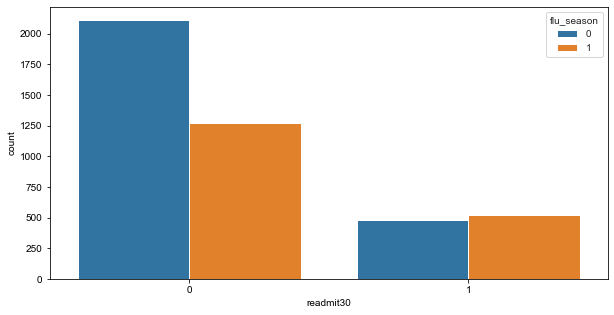

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set_style("whitegrid")
sns.countplot(x='readmit30',hue='flu_season',data=df)


In [6]:
chisquareset=pd.crosstab(index=df["readmit30"], 
                            columns=df["flu_season"],
                             margins=True,
                             normalize=False).round(2)
stat, p, dof, expected = chi2_contingency(chisquareset)

print("Chi-Square test value is " + str(stat.round(2)), " and the p value is " + str(p))
if p <= 0.05:
    print('Reject H0: There is statistically significant dependence between Readmittance and flu season')
else:
    print('Fail to reject H0: Readmittance over first 30 days does not show statistically significant dependence on flu season')


Chi-Square test value is 64.74  and the p value is 2.9153013948676207e-13
Reject H0: There is statistically significant dependence between Readmittance and flu season


# Logistic Regression

### Data-Processing

In [7]:
lr_df = df #making copy of dataset for Logistic Regression
lr_df.head()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


### Splitting Data to Train and Test Sets

In [8]:
# Select features to be used for training model
features = ['age','female','flu_season','ed_admit','severity_score','comorbidity_score']

X=lr_df[features].values
y=lr_df['readmit30'].values

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1,stratify=y)
  
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)


Number transactions X_train dataset:  (3067, 6)
Number transactions y_train dataset:  (3067,)
Number transactions X_test dataset:  (1315, 6)
Number transactions y_test dataset:  (1315,)


### Fit Logistic Regression to Training Set

In [9]:
df_train=pd.DataFrame(np.column_stack((X_train, y_train)),columns = features+['readmit30'])
df_train['readmit30']=df_train['readmit30'].astype(int)

df_test=pd.DataFrame(np.column_stack((X_test, y_test)),columns = features+['readmit30'])
df_test['readmit30']=df_test['readmit30'].astype(int)
df_train.head()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
0,85,1,0,1,14,1,0
1,81,1,0,0,1,71,0
2,81,0,1,0,1,91,0
3,71,0,1,0,9,160,1
4,76,1,1,0,3,61,0


In [10]:
formula = 'readmit30 ~ age + female + flu_season + ed_admit + severity_score + comorbidity_score'
model = smf.glm(formula = formula, data=df_train, family=sm.families.Binomial(link= sm.families.links.logit()))

result_GLM = model.fit()
print(result_GLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              readmit30   No. Observations:                 3067
Model:                            GLM   Df Residuals:                     3060
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1315.6
Date:                Mon, 17 Oct 2022   Deviance:                       2631.3
Time:                        12:43:48   Pearson chi2:                 2.97e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.8781      0.50

### Comments on Significance of Predictors and Main Drivers

At a 5% significance level, age, gender, and ed_admit are not shown to be statistically significant for determining whether a patient will be readmitted within 30 days.
However, flu season, severity score and comorbidity score have a p-value of 0, implying that there is statistical significance in determining readmittance within 30 days for a given patient.

### Interpretation of the effect of sex and comorbidity score on the 30 days readmition

Given that the p-value of the 'female' variable is 0.321, it is statistically insignificant.Comorbidity score however, is significant given p-value of 0.
The effect of comorbidity score is that an additional point is associated with a 1.7% (e^0.0169 = 1.0170436)increase in risk of readmittance within 30 days. 

### Comment on Performance of Model (at 0.5 and optimal thresholds)

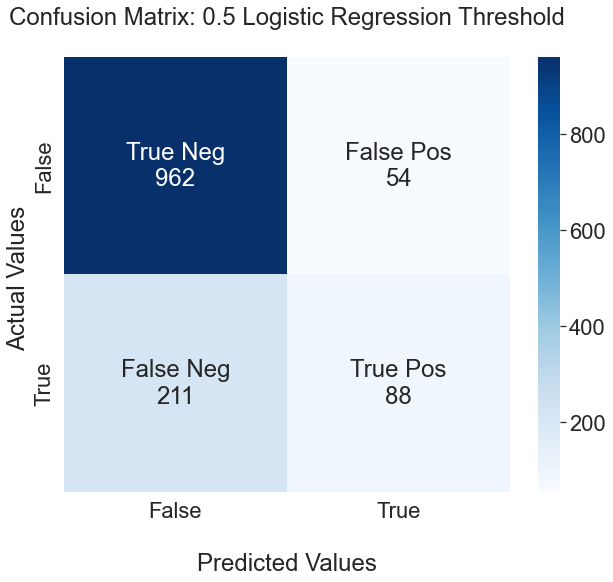

Precision: 0.62
Recall: 0.29
Accuracy: 0.8
F1-score: : 0.4


In [11]:
#calculating precision and reall
predictions = result_GLM.predict(df_test)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]

#############Plot confusion matrix
cf_matrix=confusion_matrix(df_test["readmit30"],  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix: 0.5 Logistic Regression Threshold\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(df_test["readmit30"],  predictions_nominal)
recall = recall_score(df_test["readmit30"],  predictions_nominal)
accuracy= accuracy_score(df_test["readmit30"],  predictions_nominal)
F1_score= f1_score(df_test["readmit30"],  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

Area under the ROC curve : 0.755909


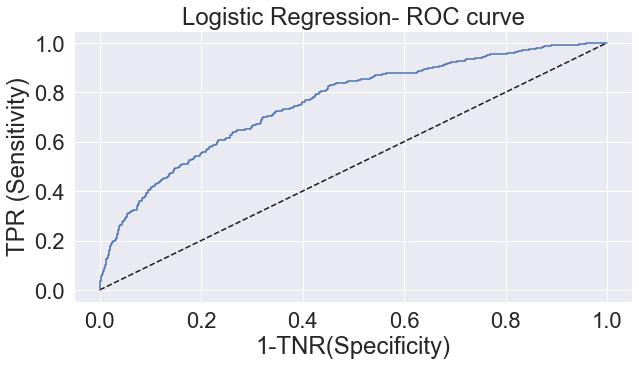

In [12]:
fpr, tpr, thresholds =roc_curve(df_test["readmit30"], predictions)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('1-TNR(Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('Logistic Regression- ROC curve')
plt.show()

          fpr       tpr     1-fpr  difference  thresholds
0    0.000000  0.000000  1.000000   -1.000000    1.943216
1    0.000000  0.003344  1.000000   -0.996656    0.943216
2    0.000000  0.016722  1.000000   -0.983278    0.901809
3    0.000984  0.016722  0.999016   -0.982293    0.895601
4    0.000984  0.036789  0.999016   -0.962226    0.850258
..        ...       ...       ...         ...         ...
416  0.943898  0.993311  0.056102    0.937209    0.037994
417  0.943898  0.996656  0.056102    0.940553    0.037738
418  0.959646  0.996656  0.040354    0.956301    0.033208
419  0.959646  1.000000  0.040354    0.959646    0.033077
420  1.000000  1.000000  0.000000    1.000000    0.016812

[421 rows x 5 columns]
          fpr       tpr     1-fpr  difference  thresholds
244  0.317913  0.685619  0.682087    0.003532    0.211935


[Text(-100.0, 0, ''),
 Text(0.0, 0, ''),
 Text(100.0, 0, ''),
 Text(200.0, 0, ''),
 Text(300.0, 0, ''),
 Text(400.0, 0, ''),
 Text(500.0, 0, '')]

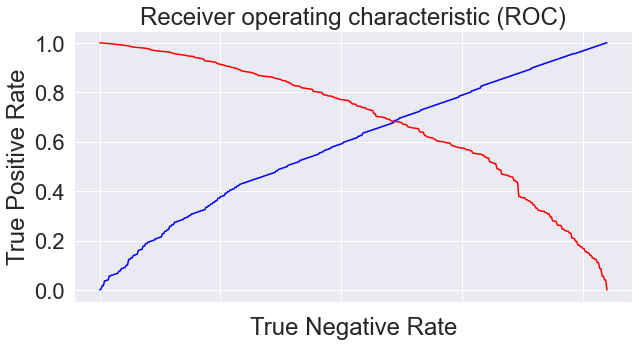

In [13]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'difference' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
print(roc)
##
print(roc.iloc[(roc.difference-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(roc['tpr'],color='blue')
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
ax.set_xticklabels([])

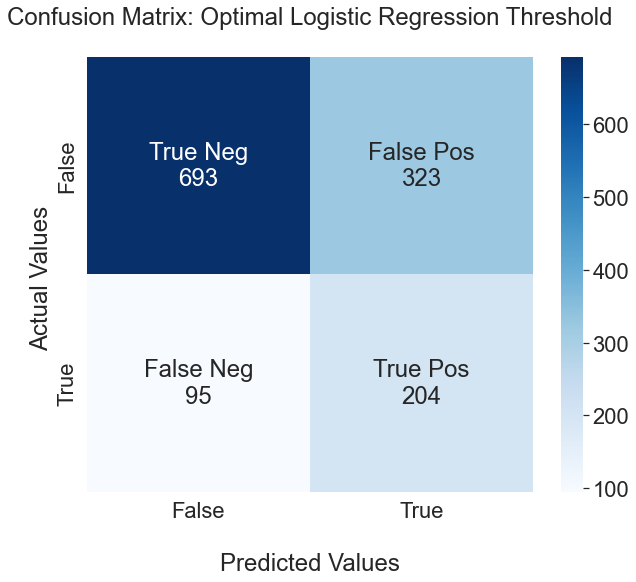

Precision: 0.39
Recall: 0.68
Accuracy: 0.68
F1-score: : 0.49


In [14]:
predictions_nominal = [ 0 if x < 0.211935 else 1 for x in predictions]


#############Plot confusion matrix
cf_matrix=confusion_matrix(df_test["readmit30"],  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix: Optimal Logistic Regression Threshold\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(df_test["readmit30"],  predictions_nominal)
recall = recall_score(df_test["readmit30"],  predictions_nominal)
accuracy= accuracy_score(df_test["readmit30"],  predictions_nominal)
F1_score= f1_score(df_test["readmit30"],  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

# K Nearest Neighbours Classification

### Data-Processing

In [15]:
knn_df = df
scaler = StandardScaler()
knn_df["age"]=scaler.fit_transform(knn_df[['age']])
knn_df["severity_score"]=scaler.fit_transform(knn_df[['severity_score']])
knn_df["comorbidity_score"]=scaler.fit_transform(knn_df[['comorbidity_score']])

### Splitting Data to Train and Test Sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Cross Validation

In [17]:
#create a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 20)}

#use gridsearch to test all values for n_neighbors using 5-fold cross validation
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

[Text(0.5, 0, ''), Text(1.5, 0, '')]

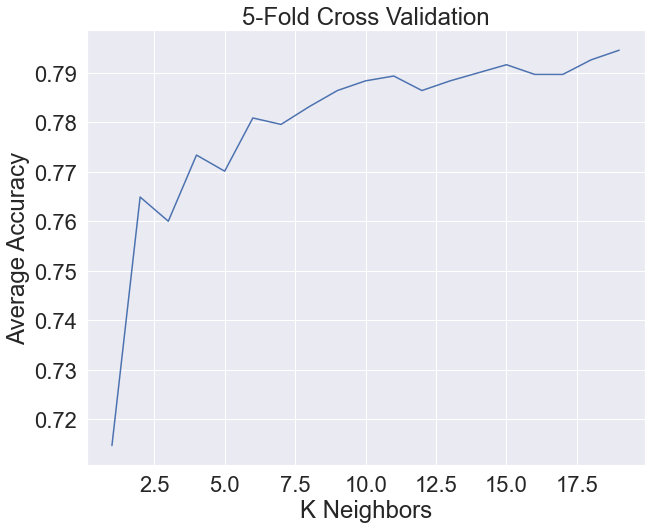

In [18]:
k_fold_result = pd.DataFrame()
k_fold_result['k'] = np.arange(1, 20)
k_fold_result['mean_test_score'] = list(knn_gscv.cv_results_['mean_test_score'])
plt.plot(k_fold_result['k'],k_fold_result['mean_test_score'])
plt.xlabel('K Neighbors')
plt.ylabel('Average Accuracy')
plt.title('5-Fold Cross Validation')
ax.set_xticklabels([])

In [19]:
#check top performing n_neighbors value 
print('Best parameters: Number of neighbors is ', knn_gscv.best_params_)

#check mean score for the top performing value of n_neighbors (mean accuracy)
print('Model accuracy (score) is:' , knn_gscv.best_score_)


Best parameters: Number of neighbors is  {'n_neighbors': 19}
Model accuracy (score) is: 0.7945937903512921


### Comment on Performance of Model (at 0.5 and optimal thresholds)

In [20]:
y_pred_proba = knn_gscv.predict_proba(X_test)[:,1]

Area under the ROC curve : 0.709047


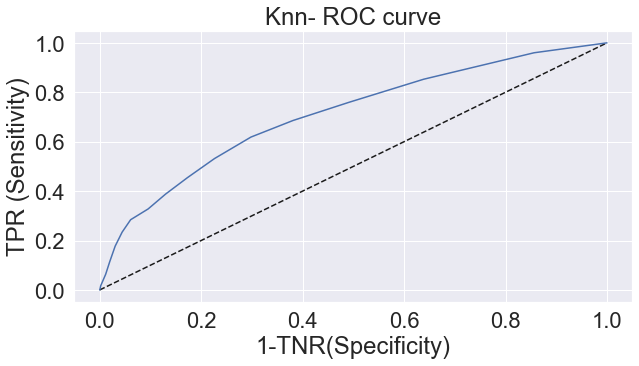

In [21]:
y_test = y_test.astype(int)
fpr, tpr, thresholds =roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('1-TNR(Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('Knn- ROC curve')
plt.show()

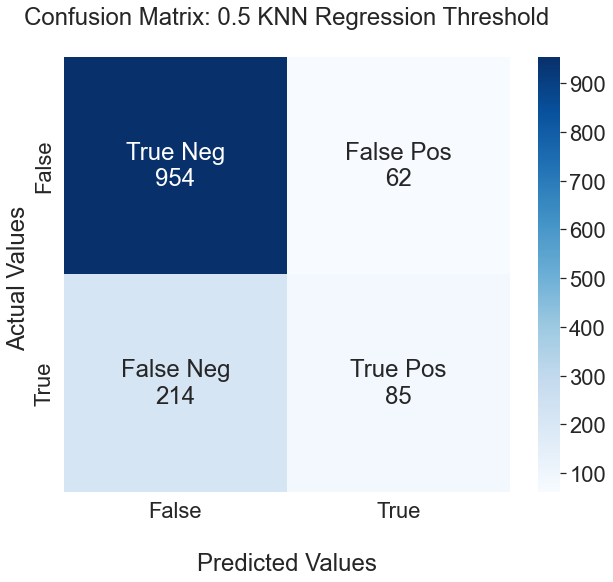

Precision: 0.58
Recall: 0.28
Accuracy: 0.79
F1-score: : 0.38


In [22]:
predictions_nominal = [ 0 if x < 0.5 else 1 for x in y_pred_proba]

#############Plot confusion matrix
cf_matrix=confusion_matrix(df_test["readmit30"],  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix: 0.5 KNN Regression Threshold\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(df_test["readmit30"],  predictions_nominal)
recall = recall_score(df_test["readmit30"],  predictions_nominal)
accuracy= accuracy_score(df_test["readmit30"],  predictions_nominal)
F1_score= f1_score(df_test["readmit30"],  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

         fpr       tpr     1-fpr  difference  thresholds
0   0.000000  0.000000  1.000000   -1.000000    1.894737
1   0.000984  0.006689  0.999016   -0.992327    0.894737
2   0.001969  0.016722  0.998031   -0.981309    0.842105
3   0.011811  0.063545  0.988189   -0.924644    0.736842
4   0.019685  0.113712  0.980315   -0.866603    0.684211
5   0.030512  0.177258  0.969488   -0.792231    0.631579
6   0.044291  0.234114  0.955709   -0.721595    0.578947
7   0.061024  0.284281  0.938976   -0.654695    0.526316
8   0.095472  0.327759  0.904528   -0.576768    0.473684
9   0.129921  0.387960  0.870079   -0.482119    0.421053
10  0.173228  0.454849  0.826772   -0.371922    0.368421
11  0.226378  0.531773  0.773622   -0.241849    0.315789
12  0.298228  0.618729  0.701772   -0.083043    0.263158
13  0.380906  0.685619  0.619094    0.066524    0.210526
14  0.491142  0.759197  0.508858    0.250339    0.157895
15  0.638780  0.852843  0.361220    0.491622    0.105263
16  0.856299  0.959866  0.14370

[Text(-2.5, 0, ''),
 Text(0.0, 0, ''),
 Text(2.5, 0, ''),
 Text(5.0, 0, ''),
 Text(7.5, 0, ''),
 Text(10.0, 0, ''),
 Text(12.5, 0, ''),
 Text(15.0, 0, ''),
 Text(17.5, 0, ''),
 Text(20.0, 0, '')]

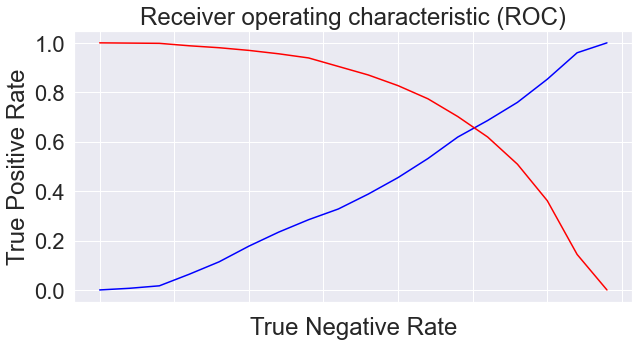

In [23]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'difference' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
print(roc)
##
print(roc.iloc[(roc.difference-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(roc['tpr'],color='blue')
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
ax.set_xticklabels([])

There is a clear difference between these ROC curves and the ones for logistic regression. 

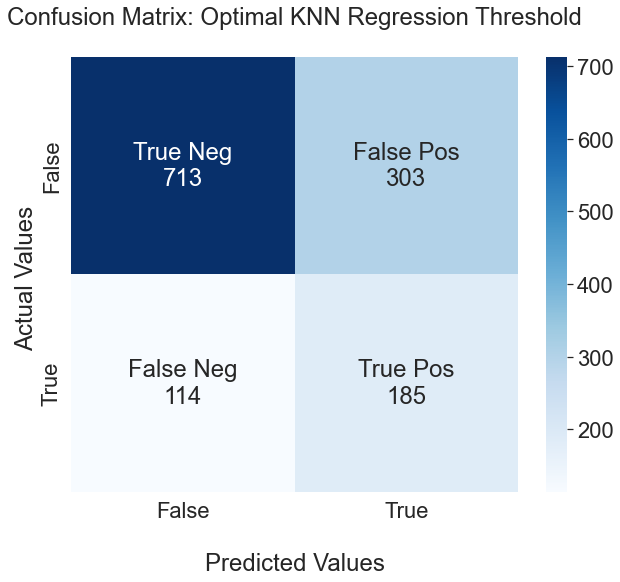

Precision: 0.38
Recall: 0.62
Accuracy: 0.68
F1-score: : 0.47


In [24]:
predictions_nominal = [ 0 if x < 0.212766 else 1 for x in y_pred_proba]

#############Plot confusion matrix
cf_matrix=confusion_matrix(df_test["readmit30"],  predictions_nominal)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(10,8)})
sns.set(font_scale = 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix: Optimal KNN Regression Threshold\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()


precision = precision_score(df_test["readmit30"],  predictions_nominal)
recall = recall_score(df_test["readmit30"],  predictions_nominal)
accuracy= accuracy_score(df_test["readmit30"],  predictions_nominal)
F1_score= f1_score(df_test["readmit30"],  predictions_nominal)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))
print('Accuracy: {}'.format(round(accuracy,2)))
print('F1-score: : {}'.format(round(F1_score,2)))

# Compare Logistic Regression and KNN Classification using ROC/AUC/F1 Score

|           | Logistic 0.5 | Logistic Optimal | KNN 0.5 | KNN Optimal |
|-----------|--------------|------------------|---------|-------------|
| AOC       | 0.76         |                  | 0.72    |             |
| Precision | 0.62         | 0.39             | 0.61    | 0.37        |
| Recall    | 0.29         | 0.68             | 0.27    | 0.65        |
| Accuracy  | 0.8          | 0.68             | 0.8     | 0.67        |
| F1-Score  | 0.4          | 0.49             | 0.38    | 0.47        |

The AUC for Logistic Recreation is 0.76 and the AUC for KNN Classification is 0.72, showing that Logistic Regression is slightly better.
The key insight from these results is that at a 0.5 threshold, KNN and Logistic Regression is very similar. So is their optimal threshold - which is very similar.

# Provide business insight from your data and models to reduce readmission rate

Since severity and comorbidity of the patient have statistically significant effects on readmittance, it is important to ensure that patients with high severity and comorbidity are not readmitted, they should be kept in the hospital for a longer period of time for a better quality recovery. I would also suggest that the said patients are transferred to a better facility with better care when possible.
Another notable factor is flu season. It has been shown to have statistical significance and therefore should be acted upon. It is possible that patients with weaker immune systems are seriously compromised during flu season leading to readmission. For said patients, it is important to receive medical assistance with their immune system and to also ensure that they are not vulnerable to easily preventable diseases through vaccination and flu shots.